In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h2o4gpu

     |████████████████████████████████| 346.3MB 14kB/s 
     |████████████████████████████████| 296kB 61.2MB/s 
     |████████████████████████████████| 6.7MB 32.8MB/s 
ERROR: umap-learn 0.5.0 has requirement scikit-learn>=0.22, but you'll have scikit-learn 0.21.2 which is incompatible.
  Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# import h2o4gpu

In [ ]:
# !pip install -U sklearn

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
# from sklearn.cluster import KMeans as kmeans
# from sklearn.cluster import Birch
from h2o4gpu.solvers.kmeans import KMeans as kmeans
from h2o4gpu.cluster import Birch
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats


In [ ]:
def read_data(path):
    #df1 = pd.read_csv(path, usecols = ["X", "Y", "Z"]) 
    #df1 = pd.read_csv(path) 
    df1 = pd.read_csv(path, usecols = [0, 1, 2]) 
    
    arr = np.array(df1)
    return arr

In [ ]:
def apply_kmeans(x,y,z,n_cl,cent):
    arr = np.empty((len(x),3))
    arr[:,0] = x
    arr[:,1] = y
    arr[:,2] = z
    
    kmn = kmeans(n_clusters=n_cl, init = cent, n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=36, copy_x=True, n_jobs=None, algorithm='auto').fit(arr[:,:2])
    label = kmn.labels_
    out = kmn.predict(arr[:,:2])
    cent = kmn.cluster_centers_
    dist = kmn.transform(arr[:,:2])
    agmn = np.argmin(dist, axis = 1)
    c_dist = np.empty_like(agmn, dtype = np.float32)
    for dst in range(len(agmn)):
        c_dist[dst] = dist[dst, agmn[dst]]    
    return (label,cent,out,c_dist)


In [ ]:
def apply_birch(x,y,z,th):
    arr = np.empty((len(x),3))
    arr[:,0] = x
    arr[:,1] = y
    arr[:,2] = z
    br = arr[:,:2]
    brc = Birch(branching_factor=50, n_clusters=None, threshold=th, compute_labels=True)
    brc.fit(br)
    label = brc.predict(br)
    out = brc.labels_
    
    cent = brc.subcluster_centers_
    dist = brc.transform(br)
    agmn = np.argmin(dist, axis = 1)
    c_dist = np.empty_like(agmn, dtype = np.float32)
    for dst in range(len(agmn)):
        c_dist[dst] = dist[dst, agmn[dst]]    
    return (label,cent,out,c_dist)


In [ ]:
def plot_kmeans(X,Y,Z,label,cent):
    
    for i in list(np.unique(label)):
        x = X[label.ravel()==i]
        y = Y[label.ravel()==i]
        z = Z[label.ravel()==i]
        plt.scatter(x,y)
    plt.scatter(cent[:,0],cent[:,1],s = 80,c = 'y', marker = 's')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.show()

In [ ]:
def adapt_buffer(x1,y1,z1,r1,lbl):
    esp = 100
    k = 0
    l1 = len(r1)
    while esp > 0.0001 and k<1000 and len(x1)>100:
        r1c1 = np.average(r1)
        z1c1 = np.average(z1)
        r1 = (r1-r1c1)
        l1 = len(r1)
        
        z1 = (z1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        x1 = (x1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        y1 = (y1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        r1 = (r1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        
        l2 = len(r1)
        r1c2 = np.average(r1)
        esp = 100*(np.absolute(r1c1 - r1c2))/(np.absolute(r1c1)+1)
        #esp = 100*(l1-l2)/(l1)
        
        k += 1
    #print('esp', esp)
    
    #print('max_iter', k)
    f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
    return()
        

In [ ]:
def zr_adjust(x1,y1,z1,r1,it_max):
    
    esp2 = 100
    kl = 0
    r2 = r1
    while esp2 > 0.0001 and kl <it_max and len(r2)>50:
        r2mn = np.min(r2)
        r2mx = np.max(r2)
        r2m = (r2mn + r2mx)/2
        rd = (r2mx -r2mn)/2 
        
        r2 = r2 - r2m
        
        z11 = z1[(r2 <= rd/2) & (r2>= -rd/2)]
        z12 = z1[(r2 > rd/2) & (r2<= -rd/2)]
        fc1 = len(z11)
        fc2 = len(z12)
        fc = np.absolute(fc1-fc2)
        if fc1>fc2:
            esp2 = 100*fc/fc1
            kl += 1
    
            ir1 = -rd/2
            ir2 = rd/2

            
        else:
            z21 = z1[(r2 >= rd/2) & (r2<= rd)]
            z22 = z1[(r2 >= -rd) & (r2<= -rd/2)]
            fc1 = len(z21)*np.ptp(z21)
            fc2 = len(z22)*np.ptp(z22)
            fc = np.absolute(fc1-fc2)
            
            if fc1>fc2:
                esp2 = 100*fc/fc1
                kl += 1

                ir1 = rd/2
                ir2 = rd
                
            else:
                esp2 = 100*fc/fc2
                kl += 1

                ir1 = -rd
                ir2 = -rd/2
                                 
        
        r1 = r1[(r2>=ir1) & (r2<=ir2)]
        r1 = r1.reshape(-1,1)
        x1 = x1[(r2>=ir1) & (r2<=ir2)]
        x1 = x1.reshape(-1,1)
        y1 = y1[(r2>=ir1) & (r2<=ir2)]
        y1 = y1.reshape(-1,1)
        z1 = z1[(r2>=ir1) & (r2<=ir2)]
        z1 = z1.reshape(-1,1)
        r2 = r2[(r2>=ir1) & (r2<=ir2)]
        r2 = r2.reshape(-1,1)

    return (x1,y1,z1,r1)


In [ ]:
def x_finder(x1,y1,z1,r1,step,itmax):
    esp2 = 100
    kl = 0
    x_2 = x1
    while esp2 > 10 and kl<itmax and np.ptp(x_2) > 0.5 and len(x_2)> step:
        
        x2mn = np.min(x_2)
        x2mx = np.max(x_2)
        x2m = (x2mn + x2mx)/2
        
        z11 = z1[(x1 >= x2mn) & (x1 <= x2m)]
        z12 = z1[(x1 > x2m) & (x1 <= x2mx)]
        fc1 = len(z11)*np.ptp(z11)
        fc2 = len(z12)*np.ptp(z12)
        fc = np.absolute(fc1-fc2)
        if fc1>fc2:
            ix1 = x2mn
            ix2 = x2m
            
            x_2 = x_2[(x_2>=ix1) & (x_2<=ix2)]
            x_2 = x_2.reshape(-1,1)
        
            esp2 = 100*fc/fc1
            kl += 1
    
        else:
            ix1 = x2m
            ix2 = x2mx
            x_2 = x_2[(x_2>=ix1) & (x_2<=ix2)]
            x_2 = x_2.reshape(-1,1)
            esp2 = 100*fc/fc2
            kl += 1
    
    ix1 = np.min(x_2)
    ix2 = np.max(x_2)
    r1 = r1[(x1>=ix1) & (x1<=ix2)]
    y1 = y1[(x1>=ix1) & (x1<=ix2)]
    z1 = z1[(x1>=ix1) & (x1<=ix2)]
    x1 = x1[(x1>=ix1) & (x1<=ix2)]
    

    x1 = x1.reshape(-1,1)
    y1 = y1.reshape(-1,1)
    z1 = z1.reshape(-1,1)
    r1 = r1.reshape(-1,1)
    return (x1,y1,z1,r1)


In [ ]:
def plot_3d(X_sub, Y_sub, Z_sub, l_sub):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation')
    for lbl in list(np.unique(l_sub)):
        ax.scatter(X_sub[l_sub == lbl], Y_sub[l_sub == lbl], Z_sub[l_sub == lbl])

    plt.show() 

In [ ]:
def plot_2d(X_sub, Y_sub, Z_sub, l_sub):
    for lbl in list(np.unique(l_sub)):
        plt.scatter(X_sub[l_sub == lbl], Y_sub[l_sub == lbl], Z_sub[l_sub == lbl])

In [ ]:
def sub_set(X,Y,Z,label,hm,hc):

    X_sub =np.empty((1,1))
    Y_sub =np.empty((1,1))
    Z_sub =np.empty((1,1))
    l_sub = np.empty((1,1))


    for lbl in list(np.unique(label)):
        x1 = (X[label == lbl]).reshape(-1,1)
        y1 = (Y[label == lbl]).reshape(-1,1) 
        z1 = (Z[label == lbl]).reshape(-1,1)
        
        x1 = (x1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        y1 = (y1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        z1 = (z1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        
        X_sub = np.concatenate((X_sub,x1))
        Y_sub = np.concatenate((Y_sub,y1))
        Z_sub = np.concatenate((Z_sub,z1))
        
        f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        
        l_sub = np.concatenate((l_sub,f_l1))
    
    X_sub = (X_sub).reshape(-1,1)
    Y_sub = (Y_sub).reshape(-1,1)
    Z_sub = (Z_sub).reshape(-1,1)
    l_sub = (l_sub).reshape(-1,1)

    X_sub = X_sub[1:,:]
    Y_sub = Y_sub[1:,:]
    Z_sub = Z_sub[1:,:]
    
    l_sub = l_sub[1:,:]
    
    return (X_sub, Y_sub, Z_sub, l_sub)


In [ ]:
def ad_buffer(X_sub, Y_sub, Z_sub, c_dist2, label2,k_max):

    X_sub2 =np.empty((1,1))
    Y_sub2 =np.empty((1,1))
    Z_sub2 =np.empty((1,1))
    R_sub2 = np.empty((1,1))
    f_sub2 = np.empty((1,1))
    fx_sub2 = np.empty((1,1))
    l_sub2 = np.empty((1,1))


    for lbl in list(np.unique(label2)):
        x1 = list(X_sub[label2 == lbl])
        y1 = list(Y_sub[label2 == lbl])   
        z1 = list(Z_sub[label2 == lbl])
        r1 = list(c_dist2[label2 == lbl])
        
        
        
        z1 = (np.array(z1)).reshape(-1,1)
        r1 = (np.array(r1)).reshape(-1,1)
        x1 = (np.array(x1)).reshape(-1,1)
        y1 = (np.array(y1)).reshape(-1,1)
        
        esp = 100
        k = 0
        l1 = len(r1)
        while esp > 0.0001 and k<k_max and len(x1)>100:
            r1c1 = np.average(r1)
            z1c1 = np.average(z1)
            r1 = (r1-r1c1)
            l1 = len(r1)
            
            z1 = (z1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
            x1 = (x1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
            y1 = (y1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
            r1 = (r1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
            
            l2 = len(r1)
            r1c2 = np.average(r1)
            esp = 100*(np.absolute(r1c1 - r1c2))/(np.absolute(r1c1)+1)
            #esp = 100*(l1-l2)/(l1)
            
            k += 1
        
        X_sub2 = np.concatenate((X_sub2,x1))
        Y_sub2 = np.concatenate((Y_sub2,y1))
        Z_sub2 = np.concatenate((Z_sub2,z1))
        
        f_num1 = (np.arange(len(r1))).reshape(-1,1)
                
        f_x1 = (np.arange(len(r1))).reshape(-1,1)
        f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        
        l_sub2 = np.concatenate((l_sub2,f_l1))
        fx_sub2 = np.concatenate((fx_sub2,f_x1))
        f_sub2 = np.concatenate((f_sub2,f_num1))
        R_sub2 = np.concatenate((R_sub2,r1))

        f_x1 = f_x1.reshape(-1,)
        f_num1 = f_num1.reshape(-1,)
        
    
    X_sub2 = (X_sub2).reshape(-1,1)
    Y_sub2 = (Y_sub2).reshape(-1,1)
    Z_sub2 = (Z_sub2).reshape(-1,1)
    f_sub2 = (f_sub2).reshape(-1,1)
    fx_sub2 = (fx_sub2).reshape(-1,1)
    l_sub2 = (l_sub2).reshape(-1,1)
    R_sub2 = (R_sub2).reshape(-1,1)


    X_sub2 = X_sub2[1:,:]
    Y_sub2 = Y_sub2[1:,:]
    Z_sub2 = Z_sub2[1:,:]
    f_sub2 = f_sub2[1:,:]
    fx_sub2 = fx_sub2[1:,:]
    l_sub2 = l_sub2[1:,:]
    R_sub2 = R_sub2[1:,:]

    return (X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2)


In [ ]:
def apply_zr(X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2,it_max):
    X_sub3 =np.empty((1,1))
    Y_sub3 =np.empty((1,1))
    Z_sub3 =np.empty((1,1))
    R_sub3 = np.empty((1,1))
    f_sub3 = np.empty((1,1))
    fx_sub3 = np.empty((1,1))
    l_sub3 = np.empty((1,1))

    for lbl in list(np.unique(l_sub2)):
        x1 = list(X_sub2[l_sub2 == lbl])
        y1= list(Y_sub2[l_sub2 == lbl])   
        z1 = list(Z_sub2[l_sub2 == lbl])
        r1 = list(R_sub2[l_sub2 == lbl])
        z1,r1,x1,y1 = zip(*sorted(zip(z1, r1,x1,y1)))
        z1 = (np.array(z1)).reshape(-1,1)
        r1 = (np.array(r1)).reshape(-1,1)
        x1 = (np.array(x1)).reshape(-1,1)
        y1 = (np.array(y1)).reshape(-1,1)
        
        if len(r1)>10:
            x1,y1,z1,r1 = zr_adjust(x1,y1,z1,r1,it_max)        
        
        X_sub3 = np.concatenate((X_sub3,x1))
        Y_sub3 = np.concatenate((Y_sub3,y1))
        Z_sub3 = np.concatenate((Z_sub3,z1))
        
        f_num1 = (np.arange(len(r1))).reshape(-1,1)
                
        f_x1 = (np.arange(len(r1))).reshape(-1,1)
        f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        

        
        l_sub3 = np.concatenate((l_sub3,f_l1))
        fx_sub3 = np.concatenate((fx_sub3,f_x1))
        f_sub3 = np.concatenate((f_sub3,f_num1))
        R_sub3 = np.concatenate((R_sub3,r1))
        
        
        f_x1 = f_x1.reshape(-1,)
        f_num1 = f_num1.reshape(-1,)
        
    
    X_sub3 = (X_sub3).reshape(-1,1)
    Y_sub3 = (Y_sub3).reshape(-1,1)
    Z_sub3 = (Z_sub3).reshape(-1,1)
    f_sub3 = (f_sub3).reshape(-1,1)
    fx_sub3 = (fx_sub3).reshape(-1,1)
    l_sub3 = (l_sub3).reshape(-1,1)
    R_sub3 = (R_sub3).reshape(-1,1)


    X_sub3 = X_sub3[1:,:]
    Y_sub3 = Y_sub3[1:,:]
    Z_sub3 = Z_sub3[1:,:]
    f_sub3 = f_sub3[1:,:]
    fx_sub3 = fx_sub3[1:,:]
    l_sub3 = l_sub3[1:,:]
    R_sub3 = R_sub3[1:,:]

    return(X_sub3, Y_sub3, Z_sub3, R_sub3, l_sub3)

In [ ]:
def apply_finder(X_sub3, Y_sub3, Z_sub3, R_sub3, l_sub3,itmax):
    X_sub4 =np.empty((1,1))
    Y_sub4 =np.empty((1,1))
    Z_sub4 =np.empty((1,1))
    R_sub4 = np.empty((1,1))
    l_sub4 = np.empty((1,1))

    for lbl in list(np.unique(l_sub3)):
        x1 = list(X_sub3[l_sub3 == lbl])
        y1= list(Y_sub3[l_sub3 == lbl])   
        z1 = list(Z_sub3[l_sub3 == lbl])
        r1 = list(R_sub3[l_sub3 == lbl])
        z1,r1,x1,y1 = zip(*sorted(zip(z1, r1,x1,y1)))
        z1 = (np.array(z1)).reshape(-1,1)
        r1 = (np.array(r1)).reshape(-1,1)
        x1 = (np.array(x1)).reshape(-1,1)
        y1 = (np.array(y1)).reshape(-1,1)
        
        if len(r1)>10:
            x1,y1,z1,r1 = x_finder(x1,y1,z1,r1,25,itmax)        
        if len(r1)>10:
            y1,x1,z1,r1 = x_finder(y1,x1,z1,r1,10,itmax)        
        
        X_sub4 = np.concatenate((X_sub4,x1))
        Y_sub4 = np.concatenate((Y_sub4,y1))
        Z_sub4 = np.concatenate((Z_sub4,z1))
        
        f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        

        l_sub4 = np.concatenate((l_sub4,f_l1))
        R_sub4 = np.concatenate((R_sub4,r1))

    
    X_sub4 = (X_sub4).reshape(-1,1)
    Y_sub4 = (Y_sub4).reshape(-1,1)
    Z_sub4 = (Z_sub4).reshape(-1,1)
    l_sub4 = (l_sub4).reshape(-1,1)
    R_sub4 = (R_sub4).reshape(-1,1)


    X_sub4 = X_sub4[1:,:]
    Y_sub4 = Y_sub4[1:,:]
    Z_sub4 = Z_sub4[1:,:]
    l_sub4 = l_sub4[1:,:]
    R_sub4 = R_sub4[1:,:]

    return (X_sub4, Y_sub4, Z_sub4, R_sub4, l_sub4)

In [ ]:
def width_finder(px, py, pz,pl):
    
    w = []
    for lbl in list(np.unique(pl)):
        x1,y1,z1 = px[pl == lbl], py[pl == lbl], pz[pl == lbl]
        
        if len(x1)<=1:
            #print('not enough points')
            w1 = 0
            #continue
        else:
            w1 = max(np.ptp(x1),np.ptp(y1))
            #print('width:', w1)
        w.append(w1)
    w = (np.array(w)).reshape(-1,1)
    dbh = np.median(w)
    #print('Median DBH:', dbh)
    return w,dbh


        

In [ ]:
# path = '/content/drive/My Drive/Excel/raw_data.csv'
path = '/content/drive/My Drive/Excel/lidar/test_data/grid1_subset_subset_input.csv'
# path = '/content/drive/My Drive/Excel/lidar/test_data/test_data3_xyz.csv'
###path = './raw_data.csv'
arr1 = read_data(path)

# QC check. removing outliers

dataset = pd.DataFrame(arr1)
# del arr1
# dataset1 = dataset[(stats.zscore(dataset.iloc[:,3:4]) < 1.96).all(axis=1)]
# dataset = dataset[(np.abs(stats.zscore(dataset.iloc[:,:])) < 2.96).all(axis=1)]
# arr1 = np.array(dataset)
# del dataset

X = arr1[:,0] 
Y = arr1[:,1] 
Z = arr1[:,2] 
    
xmax, xmin = np.max(X), np.min(X)
ymax, ymin = np.max(Y), np.min(Y)
xm = (xmax + xmin)/2
ym = (ymax + ymin)/2
X1 = X[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]
Y1 = Y[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]
Z1 = Z[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]

X2 = X[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]
Y2 = Y[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]
Z2 = Z[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]

X3 = X[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]
Y3 = Y[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]
Z3 = Z[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]

X4 = X[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]
Y4 = Y[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]
Z4 = Z[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]



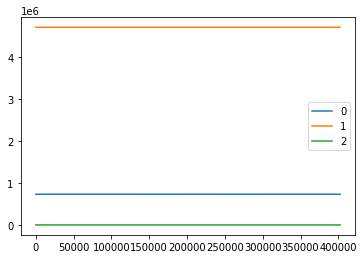

In [ ]:
plot_kmeans()

In [ ]:
print((xmax-xmin),(ymax-ymin))

285.96999999997206 236.90000000037253


In [ ]:
print(np.max(Z) - np.min(Z))

59.870000000000005


In [ ]:
arr = np.empty((len(X1),3))
arr[:,0] = X1
arr[:,1] = Y1
arr[:,2] = Z1

In [ ]:
dataset = pd.DataFrame({'Column1': X1, 'Column2': Y1,'Column3': Z1})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid1_subset_subset_input3.csv', header=None, index=None)

In [ ]:
print(X1[:5])
print(Y1[:5])
print(Z1[:5])

[731497.61 731498.31 731499.77 731499.45 731498.78]
[4712417.82 4712417.88 4712418.51 4712417.9  4712417.82]
[356.7  357.37 359.25 369.62 369.37]


In [ ]:

hm = [1.5,3,4.5,6,7.5]
hc = [0.5,0.37,0.25]

itr = [2,4,6]
ht = [1.7,2.5,3.5]

print(hm)
print(hc)
print(itr)
Xf =np.empty((1,1))
Yf =np.empty((1,1))
Zf =np.empty((1,1))
Wf = np.empty((1,len(itr)))
num_f = np.empty((1,len(itr)))
Xcntrd = []
Ycntrd = []
# x = arr[:,0]
# y = arr[:,1]
# z = arr[:,2]
x=X
y=Y
z=Z
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
z = z.reshape(-1,1)


w,h = np.abs(xmax-xmin), np.abs(ymax-ymin)
print(h,w)

hmargin = 0
wmargin = 0
# hstep = h/200
# wstep = w/200

hstep = 10
wstep = 10

ar1= (np.arange(ymin,ymax+1,hstep))
ar1 = ar1[:-1]
#print(ar1)
ar2= np.arange(xmin,xmax+1,wstep)
ar2 = ar2[:-1]
#print(ar2)

ar1 = list(ar1.ravel())
ar2 = list(ar2.ravel())

label = np.empty((len(x),1))
label = label.astype(np.uint8)
k=0
for id in ar1:
    for di in ar2:
        label[(x>=di)&(x<=di+wstep)&(y>=id)&(y <= id + hstep)] = k
        k+=1
print('label done')
del k
num_tree = len(np.unique(label))
# tree_H = np.empty(k, dtype = np.float32)
tree_H = np.empty(num_tree, dtype = np.float32)
print(label.shape,z.shape,num_tree,tree_H.shape)
for lbl in list(np.unique(label)):
    tree_H[lbl] = np.max(z[label == lbl]) - np.min(z[label == lbl])
print('height computed')
print(np.min(tree_H), np.max(tree_H),np.median(tree_H))  

DBH = []   
z = z.reshape(-1,)
label = label.reshape(-1,)
i = 0
for mh in hm:
    for ch in hc:
        
        X_sub,Y_sub,Z_sub,l_sub = sub_set(x,y, z,label,mh,ch)
        for th in ht: 
            label2,cent2,out2,c_dist2 = apply_birch(X_sub.ravel(),Y_sub.ravel(), Z_sub.ravel(),th)
            wf = np.empty((len(cent2),len(itr)))
            n_f = np.empty((len(cent2),len(itr)))
            j = 0
            for rti in itr: 
                X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2 = ad_buffer(X_sub, Y_sub, Z_sub, c_dist2, label2,k_max=rti)
                
                X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2 = apply_zr(X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2, it_max = rti)
                
                X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2 = apply_finder(X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2, itmax = rti)
                
                w,dbh = width_finder(X_sub2, Y_sub2, Z_sub2, l_sub2)
                DBH.append(dbh)
                print(i,': ',dbh)
                # a1, a2 = np.unique(l_sub, return_counts=True)
                # a1 = a1.astype(np.uint8)
                
                # wf[a1,j] = w[:,0]
                # n_f[a1,j] = a2
                
                
                Xf = np.concatenate((Xf,X_sub))
                Yf = np.concatenate((Yf,Y_sub))
                Zf = np.concatenate((Zf,Z_sub))
                # Wf = np.concatenate((Wf,wf))
                # num_f = np.concatenate((num_f,n_f))
                #Xcntrd.append(np.average(X_sub4))
                #Ycntrd.append(np.average(Y_sub4))
                i+=1
                j+=1
            #print('Wf: ',Wf.shape, num_f.shape)
Xf = (Xf).reshape(-1,1)
Yf = (Yf).reshape(-1,1)
Zf = (Zf).reshape(-1,1)
# Wf = (Wf).reshape(-1,len(itr))
# num_f = (num_f).reshape(-1,len(itr))

Xf = Xf[1:,:]
Yf = Yf[1:,:]
Zf = Zf[1:,:]
# Wf = Wf[1:,:]
# num_f = num_f[1:,:]

final_dbh = np.median(np.array(DBH))

[1.5, 3, 4.5, 6, 7.5]
[0.5, 0.37, 0.25]
[2, 4, 6]
236.90000000037253 285.96999999997206
label done
(402421, 1) (402421, 1) 256 (256,)
height computed
28.85 58.71 40.275
0 :  1.9100000001490116
1 :  1.9100000000325963
2 :  1.9100000000325963
3 :  2.019999999960419
4 :  2.0
5 :  2.0
6 :  2.0300000002607703
7 :  1.9700000000884756
8 :  1.9799999999813735
9 :  2.0
10 :  1.9899999999906868
11 :  1.9899999999906868
12 :  2.0899999999674037
13 :  2.080000000074506
14 :  2.080000000074506
15 :  2.140000000305008
16 :  2.109999999694992
17 :  2.109999999694992
18 :  1.9899999992921948
19 :  1.9800000000977889
20 :  1.9800000000977889
21 :  2.3549999996903352
22 :  2.290000000037253
23 :  2.290000000037253
24 :  2.5099999997764826
25 :  2.455000000074506
26 :  2.455000000074506
27 :  1.8200000002980232
28 :  1.8199999993667006
29 :  1.8199999993667006
30 :  1.9100000000325963
31 :  1.8999999994412065
32 :  1.900000000023283
33 :  1.8399999999674037
34 :  1.8300000000745058
35 :  1.83499999996274

In [ ]:
print(len(tree_H[tree_H>300]))


0


In [ ]:
# dataset = pd.DataFrame({'Column1': X_sub[:,0], 'Column2': Y_sub[:,0],'Column3': Z_sub[:,0], 'Column4': label2})
# dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_subset_output.csv', header=None, index=None)

In [ ]:
# dataset = pd.DataFrame({'Column1': X_sub2[:,0], 'Column2': Y_sub2[:,0],'Column3': Z_sub2[:,0], 'Column4': l_sub2[:,0]})
# dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_buffer_output.csv', header=None, index=None)

In [ ]:
# dataset = pd.DataFrame({'Column1': X_sub3[:,0], 'Column2': Y_sub3[:,0],'Column3': Z_sub3[:,0], 'Column4': l_sub3[:,0]})
# dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_zr_adjust_output.csv', header=None, index=None)

In [ ]:
# dataset = pd.DataFrame({'Column1': X_sub4[:,0], 'Column2': Y_sub4[:,0],'Column3': Z_sub4[:,0], 'Column4': l_sub4[:,0]})
# dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_xyfinder_output.csv', header=None, index=None)

In [ ]:
label_3,cent_3,out_3,c_dist_3 = apply_birch(Xf.ravel(),Yf.ravel(), Zf.ravel(),2.5)
print(len(cent_3))



In [ ]:
dataset = pd.DataFrame({'Column1': Xf[:,0], 'Column2': Yf[:,0],'Column3': Zf[:,0], 'Column4': label_3})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_after_birch_output.csv', header=None, index=None)

In [ ]:
print(len(np.unique(label_3)))

In [ ]:
label3,cent3,out3,c_dist3 = apply_kmeans(Xf.ravel(),Yf.ravel(), Zf.ravel(),len(np.unique(label_3)),'k-means++')
print(len(cent3))

In [ ]:
dataset = pd.DataFrame({'Column1': Xf[:,0], 'Column2': Yf[:,0],'Column3': Zf[:,0], 'Column4': out3})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_after_kmeans_output2.csv', header=None, index=None)

In [ ]:
plot_kmeans(Xf,Yf,Zf,label3,cent3)

In [ ]:
w = final_dbh*np.ones((len(cent3),1))
print(w.shape)
X_f = np.empty((1,1))
Y_f = np.empty((1,1))
Z_f = np.empty((1,1))
R_f = np.empty((1,1))
l_f = np.empty((1,1))

for lbl in list(np.unique(out3)):

    x1,y1,z1,r1,l1 = Xf[out3 == lbl], Yf[out3 == lbl], Zf[out3 == lbl], c_dist3[out3 == lbl], out3[out3 == lbl]
    
    x2 = x1[r1<=w[lbl]/2]
    y2 = y1[r1<=w[lbl]/2]
    z2 = z1[r1<=w[lbl]/2]
    l2 = l1[r1<=w[lbl]/2]
    r2 = r1[r1<=w[lbl]/2]

    
    x2 = x2.reshape(-1,1)
    y2 = y2.reshape(-1,1)
    z2 = z2.reshape(-1,1)
    r2 = r2.reshape(-1,1)
    l2 = l2.reshape(-1,1)
    
    
    print(len(l2))

    X_f = np.concatenate((X_f,x2))
    Y_f = np.concatenate((Y_f,y2))
    Z_f = np.concatenate((Z_f,z2))
    R_f = np.concatenate((R_f,r2))    
    l_f = np.concatenate((l_f,l2))
X_f = (X_f).reshape(-1,1)
Y_f = (Y_f).reshape(-1,1)
Z_f = (Z_f).reshape(-1,1)
R_f = (R_f).reshape(-1,1)
l_f = (l_f).reshape(-1,1)

X_f = X_f[1:,:]
Y_f = Y_f[1:,:]
Z_f = Z_f[1:,:]
R_f = R_f[1:,:]
l_f = l_f[1:,:]

In [ ]:
clabel_3 = []
#clabel_3 = list(map(''.join, zip('cl_', label_3.astype(str))))
#clabel_3 = 'cl_' + str(label_3) 

for lbl in list(l_f):
    clabel_3.append('cl_' + str(lbl+1))
print(clabel_3[15])

In [ ]:
dataset = pd.DataFrame({'Column1': X_f[:,0], 'Column2': Y_f[:,0],'Column3': Z_f[:,0], 'Column4': l_f[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_before_outlier_output.csv', header=None, index=None)

In [ ]:
w1,dbh = width_finder(X_f,Y_f,Z_f,l_f)
            
l_list = list((np.unique(l_f)).astype(np.uint8).reshape(-1,1))
print(len(l_list))
centr = np.empty((len(l_list),5), dtype = np.float32)

print(w1.shape,l_list[5])
i = 0
for k,lbl in enumerate(l_list):

    x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
    if len(z1) >1:
        centr[i,0] = np.average(x1)
        centr[i,1] = np.average(y1)
        centr[i,2] = np.max(z1)
        centr[i,3] = w1[k]
        centr[i,4] = (l_list[i]+1)
    print(centr[i,:])
    i += 1


#print(len(centr))
#dataset = pd.DataFrame(centr)
#dataset.to_csv('./ldr_full_b14_centre.csv', header=None, index=None)

In [ ]:
X_f2 = np.empty((1,1))
Y_f2 = np.empty((1,1))
Z_f2 = np.empty((1,1))
R_f2 = np.empty((1,1))
l_f2 = np.empty((1,1))


for lbl in list(np.unique(l_f)):

    x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
    
    length2 = len(l1)
    centr2 = np.empty((length2,5), dtype = np.float32)

    centr2[:,0] = x1.reshape(-1,)
    centr2[:,1] = y1.reshape(-1,)
    centr2[:,2] = z1.reshape(-1,)
    centr2[:,3] = r1.reshape(-1,)
    centr2[:,4] = l1.reshape(-1,)
    
    
    #print(centr[lbl,:])
    print(length2)
    dataset = pd.DataFrame(centr2)
    #dataset1 = dataset[(np.abs(stats.zscore(dataset.iloc[:,3:4])) < 1.96).all(axis=1)]
    dataset1 = dataset[(stats.zscore(dataset.iloc[:,3:4]) < 1.96).all(axis=1)]
    dataset2 = dataset1[(np.abs(stats.zscore(dataset1.iloc[:,2:3])) < 1.96).all(axis=1)]
    
    x2 = dataset2.iloc[:,0]
    y2 = dataset2.iloc[:,1]
    z2 = dataset2.iloc[:,2]
    r2 = dataset2.iloc[:,3]
    l2 = dataset2.iloc[:,4]

    x2 = np.array(x2).reshape(-1,1)
    y2 = np.array(y2).reshape(-1,1)
    z2 = np.array(z2).reshape(-1,1)
    r2 = np.array(r2).reshape(-1,1)
    l2 = np.array(l2).reshape(-1,1)
    
    print(len(l2))

    X_f2 = np.concatenate((X_f2,x2))
    Y_f2 = np.concatenate((Y_f2,y2))
    Z_f2 = np.concatenate((Z_f2,z2))
    R_f2 = np.concatenate((R_f2,r2))    
    l_f2 = np.concatenate((l_f2,l2))
X_f2 = (X_f2).reshape(-1,1)
Y_f2 = (Y_f2).reshape(-1,1)
Z_f2 = (Z_f2).reshape(-1,1)
R_f2 = (R_f2).reshape(-1,1)
l_f2 = (l_f2).reshape(-1,1)

X_f2 = X_f2[1:,:]
Y_f2 = Y_f2[1:,:]
Z_f2 = Z_f2[1:,:]
R_f2 = R_f2[1:,:]
l_f2 = l_f2[1:,:]


In [ ]:
w,dbh = width_finder(X_f2,Y_f2,Z_f2,l_f2)
            
l_list = list((np.unique(l_f2)).astype(np.uint8).reshape(-1,1))
centr = np.empty((len(l_list),5), dtype = np.float32)

i = 0
for k,lbl in enumerate(l_list):
    x1,y1,z1,r1,l1 = X_f2[l_f2 == lbl], Y_f2[l_f2 == lbl], Z_f2[l_f2 == lbl], R_f2[l_f2 == lbl], l_f2[l_f2 == lbl]
    
    print(w.shape,len(l_list),l_list[i])
    if len(z1) >1:
        centr[i,0] = np.average(x1)
        centr[i,1] = np.average(y1)
        centr[i,2] = np.max(z1)
        centr[i,3] = w[k]
        centr[i,4] = (l_list[i]+1)
    print(centr[i,:])
    i += 1   
    
#print(len(centr))
#dataset = pd.DataFrame(centr)
#dataset.to_csv('./ldr_full_b14_out_centre.csv', header=None, index=None)

In [ ]:
dataset = pd.DataFrame({'Column1': X_f2[:,0], 'Column2': Y_f2[:,0],'Column3': Z_f2[:,0], 'Column4': l_f2[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_outlier1_output.csv', header=None, index=None)

In [ ]:
X_f3 = np.empty((1,1))
Y_f3 = np.empty((1,1))
Z_f3 = np.empty((1,1))
R_f3 = np.empty((1,1))
l_f3 = np.empty((1,1))

a1,a2 = np.unique(l_f2,return_counts = True)
darr = np.empty((len(a1),2))
darr[:,0] = a1
darr[:,1] = a2
df3 = pd.DataFrame(darr)

df4 = df3[(df3.iloc[:,1:] > 30).all(axis=1)]

a11 = (df4.iloc[:,0])
print(len(darr))
print(len(a11))
for lbl in list(a11):
    x2,y2,z2,r2,l2 = X_f2[l_f2 == lbl], Y_f2[l_f2 == lbl], Z_f2[l_f2 == lbl], R_f2[l_f2 == lbl], l_f2[l_f2 == lbl]
    
    x2 = np.array(x2).reshape(-1,1)
    y2 = np.array(y2).reshape(-1,1)
    z2 = np.array(z2).reshape(-1,1)
    r2 = np.array(r2).reshape(-1,1)
    l2 = np.array(l2).reshape(-1,1)
    
    print(len(l2))

    X_f3 = np.concatenate((X_f3,x2))
    Y_f3 = np.concatenate((Y_f3,y2))
    Z_f3 = np.concatenate((Z_f3,z2))
    R_f3 = np.concatenate((R_f3,r2))    
    l_f3 = np.concatenate((l_f3,l2))
X_f3 = (X_f3).reshape(-1,1)
Y_f3 = (Y_f3).reshape(-1,1)
Z_f3 = (Z_f3).reshape(-1,1)
R_f3 = (R_f3).reshape(-1,1)
l_f3 = (l_f3).reshape(-1,1)

X_f3 = X_f3[1:,:]
Y_f3 = Y_f3[1:,:]
Z_f3 = Z_f3[1:,:]
R_f3 = R_f3[1:,:]
l_f3 = l_f3[1:,:]


In [ ]:
w,dbh = width_finder(X_f3,Y_f3,Z_f3,l_f3)
            
l_list = list((np.unique(l_f3)).astype(np.uint8).reshape(-1,1))
centr = np.empty((len(l_list),5), dtype = np.float32)

i = 0
for k,lbl in enumerate(l_list):
    x1,y1,z1,r1,l1 = X_f3[l_f3 == lbl], Y_f3[l_f3 == lbl], Z_f3[l_f3 == lbl], R_f3[l_f3 == lbl], l_f3[l_f3 == lbl]
    
    print(w.shape,len(l_list),l_list[i])
    if len(z1) >1:
        centr[i,0] = np.average(x1)
        centr[i,1] = np.average(y1)
        centr[i,2] = np.max(z1)
        centr[i,3] = w[k]
        centr[i,4] = (l_list[i]+1)
    print(centr[i,:])
    i += 1   
    
#print(len(centr))
#dataset = pd.DataFrame(centr)
#dataset.to_csv('./ldr_full_b14_out2__centre.csv', header=None, index=None)

In [ ]:
dataset = pd.DataFrame({'Column1': X_f3[:,0], 'Column2': Y_f3[:,0],'Column3': Z_f3[:,0], 'Column4': l_f3[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_outlier2_output.csv', header=None, index=None)

In [ ]:
X_f4 = np.empty((1,1))
Y_f4 = np.empty((1,1))
Z_f4 = np.empty((1,1))
R_f4 = np.empty((1,1))
l_f4 = np.empty((1,1))
n_f4 = np.empty((1,1))

for lbl in list(np.unique(l_f3)):

    x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
    darr2 = np.empty((len(x1),5))
    darr2[:,0] = x1
    darr2[:,1] = y1
    darr2[:,2] = z1
    darr2[:,3] = r1
    darr2[:,4] = l1
    
    
    
    
    a1,a2 = np.unique(darr2,return_counts = True, axis = 0)
    
    x2 = np.array(a1[:,0]).reshape(-1,1)
    y2 = np.array(a1[:,1]).reshape(-1,1)
    z2 = np.array(a1[:,2]).reshape(-1,1)
    r2 = np.array(a1[:,3]).reshape(-1,1)
    l2 = np.array(a1[:,4]).reshape(-1,1)
    a2 = a2.reshape(-1,1)
    #print(len(a2))

    X_f4 = np.concatenate((X_f4,x2))
    Y_f4 = np.concatenate((Y_f4,y2))
    Z_f4 = np.concatenate((Z_f4,z2))
    R_f4 = np.concatenate((R_f4,r2))    
    l_f4 = np.concatenate((l_f4,l2))
    n_f4 = np.concatenate((n_f4,a2))    
    
X_f4 = (X_f4).reshape(-1,1)
Y_f4 = (Y_f4).reshape(-1,1)
Z_f4 = (Z_f4).reshape(-1,1)
R_f4 = (R_f4).reshape(-1,1)
l_f4 = (l_f4).reshape(-1,1)
n_f4 = (n_f4).reshape(-1,1)

X_f4 = X_f4[1:,:]
Y_f4 = Y_f4[1:,:]
Z_f4 = Z_f4[1:,:]
R_f4 = R_f4[1:,:]
l_f4 = l_f4[1:,:]
n_f4 = n_f4[1:,:]



In [ ]:
dataset = pd.DataFrame({'Column1': X_f4[:,0], 'Column2': Y_f4[:,0],'Column3': Z_f4[:,0], 'Column4': l_f4[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_unique_pts_output.csv', header=None, index=None)

In [ ]:
X_f5 = np.empty((1,1))
Y_f5 = np.empty((1,1))
Z_f5 = np.empty((1,1))
R_f5 = np.empty((1,1))
l_f5 = np.empty((1,1))

for lbl in list(np.unique(l_f4)):
    
    x1,y1,z1,r1,l1 = X_f4[l_f4 == lbl], Y_f4[l_f4 == lbl], Z_f4[l_f4 == lbl], R_f4[l_f4 == lbl], l_f4[l_f4 == lbl]
    
    length2 = len(l1)
    centr2 = np.empty((length2,5), dtype = np.float32)

    centr2[:,0] = x1.reshape(-1,)
    centr2[:,1] = y1.reshape(-1,)
    centr2[:,2] = z1.reshape(-1,)
    centr2[:,3] = r1.reshape(-1,)
    centr2[:,4] = l1.reshape(-1,)
    
    
    
    print(length2)
    dataset = pd.DataFrame(centr2)
    
    dataset1 = dataset[(stats.zscore(dataset.iloc[:,3:4]) < 1.96).all(axis=1)]
    dataset2 = dataset1[(np.abs(stats.zscore(dataset1.iloc[:,2:3])) < 1.96).all(axis=1)]
    
    x2 = dataset2.iloc[:,0]
    y2 = dataset2.iloc[:,1]
    z2 = dataset2.iloc[:,2]
    r2 = dataset2.iloc[:,3]
    l2 = dataset2.iloc[:,4]

    x2 = np.array(x2).reshape(-1,1)
    y2 = np.array(y2).reshape(-1,1)
    z2 = np.array(z2).reshape(-1,1)
    r2 = np.array(r2).reshape(-1,1)
    l2 = np.array(l2).reshape(-1,1)
    
    print(len(l2))

    X_f5 = np.concatenate((X_f5,x2))
    Y_f5 = np.concatenate((Y_f5,y2))
    Z_f5 = np.concatenate((Z_f5,z2))
    R_f5 = np.concatenate((R_f5,r2))    
    l_f5 = np.concatenate((l_f5,l2))
X_f5 = (X_f5).reshape(-1,1)
Y_f5 = (Y_f5).reshape(-1,1)
Z_f5 = (Z_f5).reshape(-1,1)
R_f5 = (R_f5).reshape(-1,1)
l_f5 = (l_f5).reshape(-1,1)

X_f5 = X_f5[1:,:]
Y_f5 = Y_f5[1:,:]
Z_f5 = Z_f5[1:,:]
R_f5 = R_f5[1:,:]
l_f5 = l_f5[1:,:]


In [ ]:
dataset = pd.DataFrame({'Column1': X_f5[:,0], 'Column2': Y_f5[:,0],'Column3': Z_f5[:,0], 'Column4': l_f5[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_outlier3_unique_pts_output.csv', header=None, index=None)

In [ ]:
X_f6 = np.empty((1,1))
Y_f6 = np.empty((1,1))
Z_f6 = np.empty((1,1))
R_f6 = np.empty((1,1))
l_f6 = np.empty((1,1))


a1,a2 = np.unique(l_f5,return_counts = True)
darr = np.empty((len(a1),2))
darr[:,0] = a1
darr[:,1] = a2
df3 = pd.DataFrame(darr)

# df4 = df3[(df3.iloc[:,1:] > 30).all(axis=1)]

# a11 = (df4.iloc[:,0])
a11 = (df3.iloc[:,0])
print(len(darr))
print(len(a11))
for lbl in list(a11):
    x2,y2,z2,r2,l2 = X_f5[l_f5 == lbl], Y_f5[l_f5 == lbl], Z_f5[l_f5 == lbl], R_f5[l_f5 == lbl], l_f5[l_f5 == lbl]
    
    x2 = np.array(x2).reshape(-1,1)
    y2 = np.array(y2).reshape(-1,1)
    z2 = np.array(z2).reshape(-1,1)
    r2 = np.array(r2).reshape(-1,1)
    l2 = np.array(l2).reshape(-1,1)
    
    print(len(l2))

    X_f6 = np.concatenate((X_f6,x2))
    Y_f6 = np.concatenate((Y_f6,y2))
    Z_f6 = np.concatenate((Z_f6,z2))
    R_f6 = np.concatenate((R_f6,r2))    
    l_f6 = np.concatenate((l_f6,l2))
X_f6 = (X_f6).reshape(-1,1)
Y_f6 = (Y_f6).reshape(-1,1)
Z_f6 = (Z_f6).reshape(-1,1)
R_f6 = (R_f6).reshape(-1,1)
l_f6 = (l_f6).reshape(-1,1)

X_f6 = X_f6[1:,:]
Y_f6 = Y_f6[1:,:]
Z_f6 = Z_f6[1:,:]
R_f6 = R_f6[1:,:]
l_f6 = l_f6[1:,:]


In [ ]:
dataset = pd.DataFrame({'Column1': X_f6[:,0], 'Column2': Y_f6[:,0],'Column3': Z_f6[:,0], 'Column4': l_f6[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_outlier4_unique_pts_output.csv', header=None, index=None)

In [ ]:
w,dbh = width_finder(X_f6,Y_f6,Z_f6,l_f6)
            
l_list = list((np.unique(l_f6)).astype(np.uint8).reshape(-1,1))
centr = np.empty((len(l_list),5), dtype = np.float32)

i = 0
for k,lbl in enumerate(l_list):
    x1,y1,z1,r1,l1 = X_f6[l_f6 == lbl], Y_f6[l_f6 == lbl], Z_f6[l_f6 == lbl], R_f6[l_f6 == lbl], l_f6[l_f6 == lbl]

    print(w.shape,len(l_list),l_list[i])
    if len(z1) >1:
        centr[i,0] = np.average(x1)
        centr[i,1] = np.average(y1)
        centr[i,2] = np.max(z1)
        centr[i,3] = w[k]
        centr[i,4] = (l_list[i]+1)
    print(centr[i,:])
    i += 1   
    
#print(len(centr))
#dataset = pd.DataFrame(centr)
#dataset.to_csv('./ldr_full_b14_out4__centre.csv', header=None, index=None)

In [ ]:
X_f7 = np.empty((1,1))
Y_f7 = np.empty((1,1))
Z_f7 = np.empty((1,1))
R_f7 = np.empty((1,1))
l_f7 = np.empty((1,1))


for lbl in list(np.unique(l_f6)):
    x1,y1,z1,r1,l1 = X_f6[l_f6 == lbl], Y_f6[l_f6 == lbl], Z_f6[l_f6 == lbl], R_f6[l_f6 == lbl], l_f6[l_f6 == lbl]

    xmax,xmin = np.max(x1), np.min(x1)
    ymax,ymin = np.max(y1), np.min(y1)
    zmin = np.min(Z[(X<=xmax) & (X>=xmin) & (Y<=ymax) & (Y>=ymin)]) + 5
    zmax = zmin + 10
    
    x2 = x1[(z1<=zmax) & (z1>=zmin)]
    y2 = y1[(z1<=zmax) & (z1>=zmin)]
    z2 = z1[(z1<=zmax) & (z1>=zmin)]
    r2 = r1[(z1<=zmax) & (z1>=zmin)]
    l2 = l1[(z1<=zmax) & (z1>=zmin)]
    
    x2 = np.array(x2).reshape(-1,1)
    y2 = np.array(y2).reshape(-1,1)
    z2 = np.array(z2).reshape(-1,1)
    r2 = np.array(r2).reshape(-1,1)
    l2 = np.array(l2).reshape(-1,1)
    
    print(len(l2))

    X_f7 = np.concatenate((X_f7,x2))
    Y_f7 = np.concatenate((Y_f7,y2))
    Z_f7 = np.concatenate((Z_f7,z2))
    R_f7 = np.concatenate((R_f7,r2))    
    l_f7 = np.concatenate((l_f7,l2))
X_f7 = (X_f7).reshape(-1,1)
Y_f7 = (Y_f7).reshape(-1,1)
Z_f7 = (Z_f7).reshape(-1,1)
R_f7 = (R_f7).reshape(-1,1)
l_f7 = (l_f7).reshape(-1,1)

X_f7 = X_f7[1:,:]
Y_f7 = Y_f7[1:,:]
Z_f7 = Z_f7[1:,:]
R_f7 = R_f7[1:,:]
l_f7 = l_f7[1:,:]                

In [ ]:
print(len(R_f7), len(l_f7), len(X_f7),len(Y_f7), len(Z_f7))
dataset = pd.DataFrame({'Column1': X_f7[:,0], 'Column2': Y_f7[:,0],'Column3': Z_f7[:,0], 'Column4': R_f7[:,0],'Column5': l_f7[:,0]})
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_height_subset_unique_pts_output.csv', header=None, index=None)

In [ ]:
w,dbh = width_finder(X_f7,Y_f7,Z_f7,l_f7)
            
l_list = list((np.unique(l_f7)).astype(np.uint8).reshape(-1,1))
centr = np.empty((len(l_list),5), dtype = np.float32)

i = 0
for k,lbl in enumerate(l_list):
    x1,y1,z1,r1,l1 = X_f7[l_f7 == lbl], Y_f7[l_f7 == lbl], Z_f7[l_f7 == lbl], R_f7[l_f7 == lbl], l_f7[l_f7 == lbl]

    print(w.shape,len(l_list),l_list[i])
    if len(z1) >1:
        centr[i,0] = np.average(x1)
        centr[i,1] = np.average(y1)
        centr[i,2] = np.max(z1)
        centr[i,3] = w[k]
        centr[i,4] = (l_list[i]+1)
    print(centr[i,:])
    i += 1   
    
print(len(centr))
dataset = pd.DataFrame(centr)
dataset.to_csv('/content/drive/My Drive/Excel/lidar/test_data/grid3_height_subset_unique_pts_output_centre.csv', header=None, index=None)